In [283]:
import matplotlib.pyplot as plt
from math import atan2

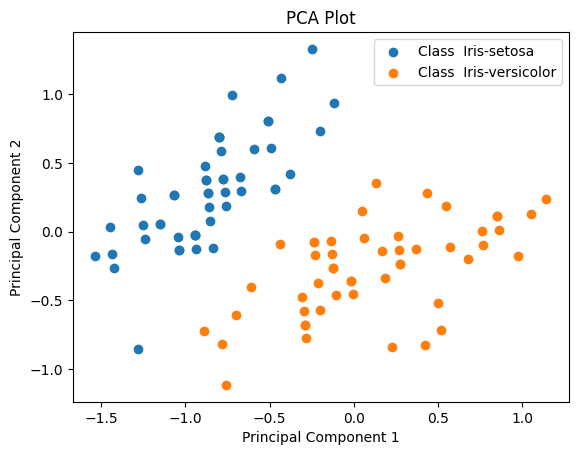

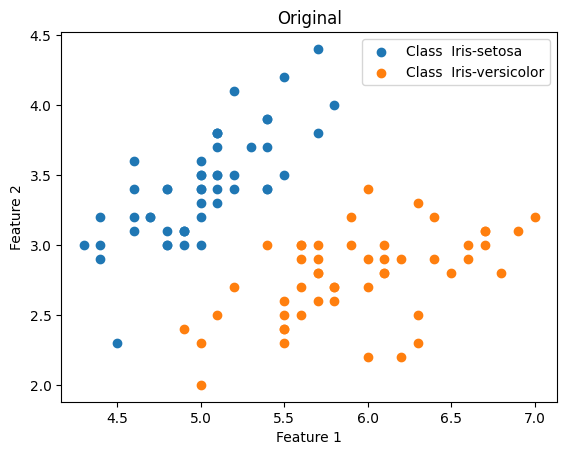

In [284]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

class Point:
    def __init__(self, coordx, coordy):
        self.x = coordx
        self.y = coordy

class Group:
    def __init__(self):
        self.points_group = []

    def add_point(self, point):
        self.points_group.append(point)

def perform_pca_and_plot(dataset):
    data_points = []

    with open(dataset, "r") as file:
        lines = file.readlines()

    data_start = lines.index("@data\n") + 1

    class_labels = []

    for line in lines[data_start:]:
        data = line.strip().split(',')
        data_points.append([float(data[0]), float(data[1])])
        class_labels.append(data[-1])

    X = np.array(data_points, dtype=float)
    class_labels = np.array(class_labels)

    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    unique_labels = np.unique(class_labels)
    first_two_labels = unique_labels[:2]

    for label in first_two_labels:
        mask = (class_labels == label)
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=f'Class {label}')

    # 70% of the data is used for training and 30% for testing
    training = int(0.7 * len(X_2d))
    testing = len(X_2d) - training

    group1 = Group()
    group2 = Group()

    for i in range(training):
        if class_labels[i] in first_two_labels:
            if class_labels[i] == first_two_labels[0]:
                group1.add_point(Point(X_2d[i][0], X_2d[i][1]))
            else:
                group2.add_point(Point(X_2d[i][0], X_2d[i][1]))

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA Plot")
    plt.legend()
    plt.show()

    # Plot original data
    plt.figure()

    for label in first_two_labels:
        mask = (class_labels == label)
        plt.scatter(X[mask, 0], X[mask, 1], label=f'Class {label}')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Original")
    plt.legend()

    plt.show()

    return group1, group2


datafile = ('iris.dat')
group1, group2 = perform_pca_and_plot(datafile)

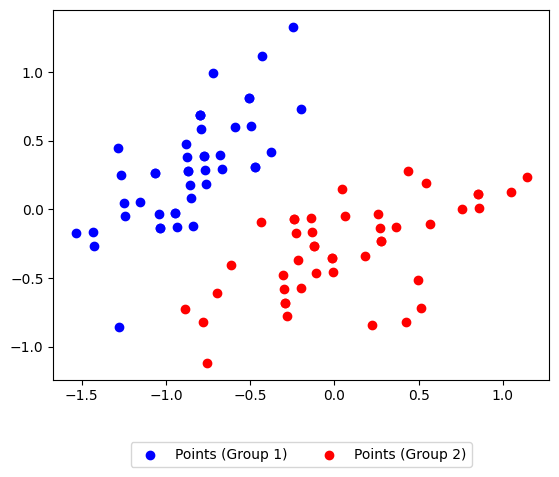

In [285]:
# plotando os pontos de cada grupo
group1_all_points_x = [point.x for point in group1.points_group]
group1_all_points_y = [point.y for point in group1.points_group]
group2_all_points_x = [point.x for point in group2.points_group]
group2_all_points_y = [point.y for point in group2.points_group]
plt.scatter(group1_all_points_x, group1_all_points_y, color='b', label='Points (Group 1)')
plt.scatter(group2_all_points_x, group2_all_points_y, color='r', label='Points (Group 2)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

## Plot feixo convexo do conjunto dos pontos em dois gráficos separados

In [286]:
def orientation(p, q, r):
    """
    Função para verificar a orientação dos pontos (p, q, r).
    Retorna os seguintes valores:
    -1 se estão no sentido horário.
    0 se são colineares.
    1 se estão no sentido anti-horário.
    """
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0
    return 1 if val > 0 else -1

def graham_scan(points):
    n = len(points)
    if n < 3:
        return []

    # Encontre o ponto com a menor coordenada y (e à esquerda, se houver um empate)
    min_point = min(points, key=lambda point: (point.y, point.x))

    # Classifique os pontos com base em suas polaridades em relação ao ponto mínimo
    sorted_points = sorted(points, key=lambda point: (atan2(point.y - min_point.y, point.x - min_point.x), point.x, point.y))

    # Inicialize a pilha e adicione os dois primeiros pontos
    stack = [sorted_points[0], sorted_points[1]]

    # Itere pelos pontos restantes
    for i in range(2, n):
        while len(stack) > 1 and orientation(stack[-2], stack[-1], sorted_points[i]) != -1:
            stack.pop()
        stack.append(sorted_points[i])

    return stack

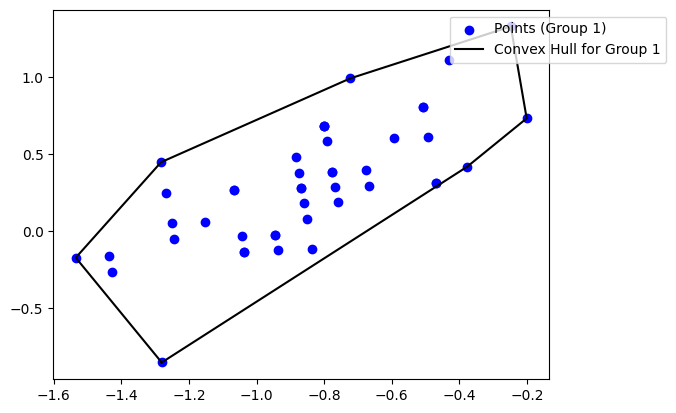

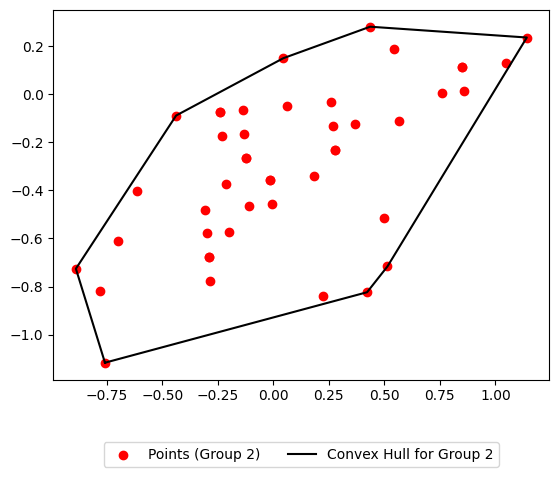

In [287]:
# Encontrando o convex hull para cada grupo
convex1_hull = graham_scan(group1.points_group)
convex2_hull = graham_scan(group2.points_group)

# Plot pontos grupo 1
group1_x = [point.x for point in convex1_hull] + [convex1_hull[0].x]
group1_y = [point.y for point in convex1_hull] + [convex1_hull[0].y]
plt.scatter(group1_all_points_x, group1_all_points_y, color='b', label='Points (Group 1)')
plt.plot(group1_x, group1_y, color='black', label='Convex Hull for Group 1')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

# Plot pontos grupo 2
group2_x = [point.x for point in convex2_hull] + [convex2_hull[0].x]
group2_y = [point.y for point in convex2_hull] + [convex2_hull[0].y]
plt.scatter(group2_all_points_x, group2_all_points_y, color='r', label='Points (Group 2)')
plt.plot(group2_x, group2_y, color='black', label='Convex Hull for Group 2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

In [288]:
# algoritmo de varredura para verificar se as arestas do convex hull de um grupo intersectam as arestas do convex hull do outro grupo
def is_on_segment(p, q, r):
    return (min(p.x, q.x) <= r.x <= max(p.x, q.x) and
            min(p.y, q.y) <= r.y <= max(p.y, q.y))

def do_segments_intersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and is_on_segment(p1, q1, p2):
        return True
    if o2 == 0 and is_on_segment(p1, q1, q2):
        return True
    if o3 == 0 and is_on_segment(p2, q2, p1):
        return True
    if o4 == 0 and is_on_segment(p2, q2, q1):
        return True

    return False

# Verificar a interseção entre as arestas do convex hull dos grupos
intersects = False
number_of_intersections = 0
intersection_segments = []

convex1_hull.append(convex1_hull[0])
convex2_hull.append(convex2_hull[0])

for i in range(len(convex1_hull) - 1):
    for j in range(len(convex2_hull) - 1):
        if do_segments_intersect(convex1_hull[i], convex1_hull[i + 1], convex2_hull[j], convex2_hull[j + 1]):
            intersects = True
            intersection_segments.append((convex1_hull[i], convex1_hull[i + 1], convex2_hull[j], convex2_hull[j + 1]))
            number_of_intersections += 1

if intersects:
    print(f"Os grupos têm {number_of_intersections} interseções nas arestas do convex hull.")
    plt.plot(group1_x, group1_y, color='b', label='Convex Hull for Group 1')
    plt.plot(group2_x, group2_y, color='r', label='Convex Hull for Group 2')
    for inter_segment in intersection_segments:
        x_coords1 = [inter_segment[0].x, inter_segment[1].x]
        y_coords1 = [inter_segment[0].y, inter_segment[1].y]
        x_coords2 = [inter_segment[2].x, inter_segment[3].x]
        y_coords2 = [inter_segment[2].y, inter_segment[3].y]
        plt.plot(x_coords2, y_coords2, color='green')
        plt.plot(x_coords1, y_coords1, color='green')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.show()
else:
    print("Os grupos não têm interseções nas arestas do convex hull.")


Os grupos não têm interseções nas arestas do convex hull.


## Plot do feixo convexo do conjunto dos pontos em um gráfico só

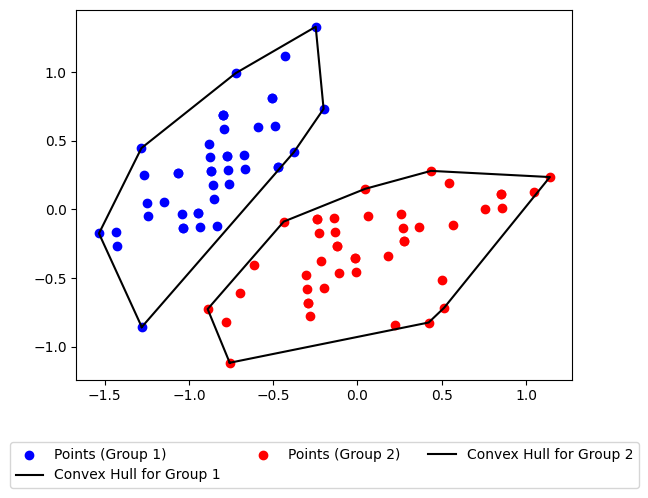

In [289]:
plt.scatter(group1_all_points_x, group1_all_points_y, color='b', label='Points (Group 1)')
plt.plot(group1_x, group1_y, color='black', label='Convex Hull for Group 1')
plt.scatter(group2_all_points_x, group2_all_points_y, color='r', label='Points (Group 2)')
plt.plot(group2_x, group2_y, color='black', label='Convex Hull for Group 2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

In [290]:
def distance_squared(point1, point2):
    return (point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2

def closest_points(hull_group1, hull_group2):
    min_distance = float('inf')
    closest_points = None

    for point1 in hull_group1:
        for point2 in hull_group2:
            distance = distance_squared([point1.x, point1.y], [point2.x, point2.y])
            if distance < min_distance:
                min_distance = distance
                closest_points = [[point1.x, point1.y], [point2.x, point2.y]]

    return closest_points


Close points
Group1: [-1.2802771519151483, -0.856709319856205]
Group2: [-0.8893189690799491, -0.7257448236207783]


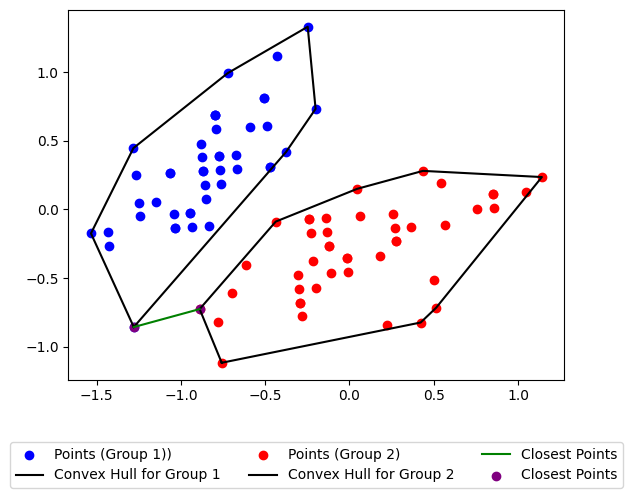

In [291]:
close_points = closest_points(convex1_hull, convex2_hull)
print(f"Close points\nGroup1: {close_points[0]}\nGroup2: {close_points[1]}")
plt.scatter(group1_all_points_x, group1_all_points_y, color='b', label='Points (Group 1))')
plt.plot(group1_x, group1_y, color='black', label='Convex Hull for Group 1')
plt.scatter(group2_all_points_x, group2_all_points_y, color='r', label='Points (Group 2)')
plt.plot(group2_x, group2_y, color='black', label='Convex Hull for Group 2')
plt.plot([close_points[0][0], close_points[1][0]], [close_points[0][1], close_points[1][1]], color='green', label='Closest Points')
plt.scatter([close_points[0][0], close_points[1][0]], [close_points[0][1], close_points[1][1]], color='purple', label='Closest Points')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

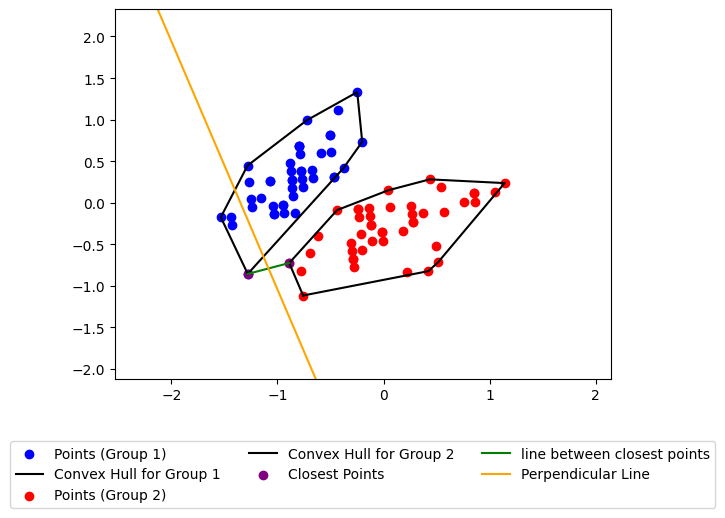

In [292]:
# Criando uma reta perpendicular ao segmento de reta que une os pontos mais próximos
# Calculando a inclinação da reta
slope = (close_points[1][1] - close_points[0][1]) / (close_points[1][0] - close_points[0][0])
# Calculando o ponto médio entre os pontos mais próximos
mid_point = [(close_points[0][0] + close_points[1][0]) / 2, (close_points[0][1] + close_points[1][1]) / 2]
# Calculando o ponto médio entre os pontos mais próximos
perpendicular_slope = -1 / slope
# Calculando o ponto médio entre os pontos mais próximos
perpendicular_mid_point = [mid_point[0], mid_point[1]]
# Calculando os pontos extremos da reta perpendicular
perpendicular_point1 = [perpendicular_mid_point[0] + 10, perpendicular_mid_point[1] + 10 * perpendicular_slope]
perpendicular_point2 = [perpendicular_mid_point[0] - 10, perpendicular_mid_point[1] - 10 * perpendicular_slope]
# Plotando os pontos, mas agora com a reta perpendicular e limitando o gráfico para nao diminuir a qualidade da visualização
# O limite sera um pouco maior que o x mais a direita e o x mais a esquerda
# O limite sera um pouco maior que o y mais a cima e o y mais a baixo
plt.scatter(group1_all_points_x, group1_all_points_y, color='b', label='Points (Group 1)')
plt.plot(group1_x, group1_y, color='black', label='Convex Hull for Group 1')
plt.scatter(group2_all_points_x, group2_all_points_y, color='r', label='Points (Group 2)')
plt.plot(group2_x, group2_y, color='black', label='Convex Hull for Group 2')
plt.scatter([close_points[0][0], close_points[1][0]], [close_points[0][1], close_points[1][1]], color='purple', label='Closest Points')
plt.plot([close_points[0][0], close_points[1][0]], [close_points[0][1], close_points[1][1]], color='green', label='line between closest points')
plt.plot([perpendicular_point1[0], perpendicular_point2[0]], [perpendicular_point1[1], perpendicular_point2[1]], color='orange', label='Perpendicular Line')
plt.xlim([min(group1_all_points_x + group2_all_points_x) - 1, max(group1_all_points_x + group2_all_points_x) + 1])
plt.ylim([min(group1_all_points_y + group2_all_points_y) - 1, max(group1_all_points_y + group2_all_points_y) + 1])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

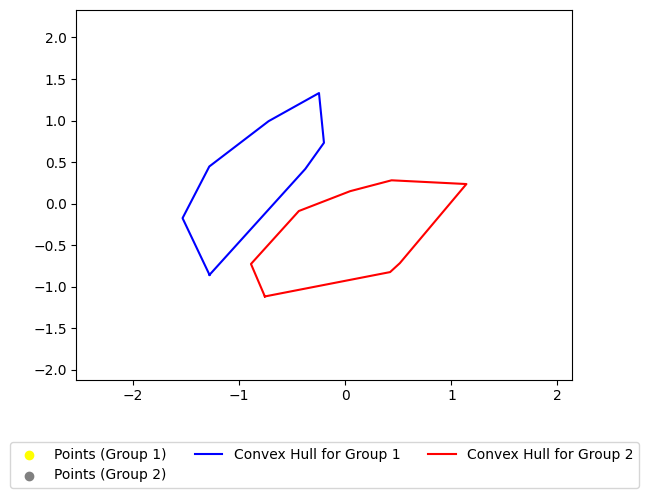

ZeroDivisionError: ignored

In [301]:
"""
restante_pontos = []
# verifica a distancia de todos os pontos restantes de teste para os pontos mais proximos
# de quem o ponto esta mais proximo, ele pertence a esse grupo
acertos = 0
erros = 0
group = 0
for line in teste:
    line = line.split(',')
    point = [float(line[col1 - 1]), float(line[col2 - 1])]
    actualClass = line[len(line) - 1].rstrip()
    if actualClass == classe1 or actualClass == classe2:
        if distance_squared(point, close_points[0]) < distance_squared(point, close_points[1]):
            restante_pontos.append((point, 1))
            group =  classe1
        else:
            restante_pontos.append((point, -1))
            group = classe2
        if actualClass == group:
            acertos += 1
        else:
            erros += 1

# plotando os pontos de teste
group1_teste_x = [point[0][0] for point in restante_pontos if point[1] == 1]
group1_teste_y = [point[0][1] for point in restante_pontos if point[1] == 1]
group2_teste_x = [point[0][0] for point in restante_pontos if point[1] == -1]
group2_teste_y = [point[0][1] for point in restante_pontos if point[1] == -1]
plt.scatter(group1_teste_x, group1_teste_y, color='yellow', label='Points (Group 1)')
plt.scatter(group2_teste_x, group2_teste_y, color='gray', label='Points (Group 2)')
plt.plot(group1_x, group1_y, color='b', label='Convex Hull for Group 1')
plt.plot(group2_x, group2_y, color='r', label='Convex Hull for Group 2')
plt.plot([perpendicular_point1[0], perpendicular_point2[0]], [perpendicular_point1[1], perpendicular_point2[1]], color='orange', label='Perpendicular Line')
plt.xlim([min(group1_all_points_x + group2_all_points_x) - 1, max(group1_all_points_x + group2_all_points_x) + 1])
plt.ylim([min(group1_all_points_y + group2_all_points_y) - 1, max(group1_all_points_y + group2_all_points_y) + 1])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

print(f"DataSet: {fileName}\nClasse1: {classe1}\nClasse2: {classe2}\nAtributo1: {atr1}\nAtributo2: {atr2}\nAcurácia {acertos / len(restante_pontos)}\nAcertos: {acertos}\nErros: {erros}")
"""